# Figure 12.

Snapshot of convection in the substellar region in the Proxima b case at the end of *HighRes* simulation. Colors show (a) precipitation rate ($mm~day^{-1}$) and (b) upward vertical velocity ($m~s^{-1}$) at $\approx2500$ altitude.

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

Scientific stack

In [3]:
import cartopy.crs as ccrs
import iris

import numpy as np

import matplotlib.pyplot as plt

In [4]:
from aeolus.calc import precip_sum
from aeolus.coord_utils import UM_LATLON
from aeolus.core import Run
from aeolus.plot import label_global_map_gridlines
from aeolus.region import Region
from aeolus.util import subplot_label_generator

Local modules

In [5]:
from commons import (
    FCST_PRD_CNSTR,
    NS_MODEL_TYPES,
    NS_RUNID,
)
import mypaths
from plot_func import use_style, CART_KW
from proc_um_output import process_cubes
from utils import tex2cf_units

Global stylesheet for figures.

In [6]:
use_style()

A few local definitions

In [7]:
planet = "proxb"
run_key = "grcs"
model_type = "lam"

OUTPUT_NAME_PREFIX = f"{planet}_{run_key}"

Define the region to zoom in to in the figure.

In [8]:
ss_region = Region(-10, 30, -20, 20, "HighRes domain")

extent = [i["value"] for i in ss_region]

Set metadata for the variables.

In [9]:
vrbls2plot = {
    "precip": {
        "func": lambda cl: precip_sum(cl),
        "plt_kw": dict(cmap="cubehelix_r", vmin=0, vmax=32),
        "title": "Precipitation rate",
        "tex_units": "$mm$ $day^{-1}$",
    },
    "w": {
        "func": lambda cl: cl.extract_strict("upward_air_velocity").extract(
            iris.Constraint(level_height=2500)
        ),
        "plt_kw": dict(cmap="seismic", vmin=-0.5, vmax=0.5),
        "title": "Upward air velocity",
        "tex_units": "$m$ $s^{-1}$",
    },
}

## Load data

Create a dictionary of `Run` objects with UM data.

In [10]:
runs = {}
subdir = f"{planet}_{run_key}"
label = f"{planet}_{run_key}_{model_type}"
fpath = (
    mypaths.nsdir
    / subdir
    / "*"
    / NS_MODEL_TYPES["lam"]["path"].parent
    / f"{NS_RUNID}_pa*"
)
# Load data
run = Run(files=fpath, name=label, planet=planet, model_type=model_type,)
# Regrid & interpolate data
run.proc_data(
    process_cubes, extract_mean=False, regrid_multi_lev=False,
)
# Select domain
run.proc = run.proc.extract(FCST_PRD_CNSTR)
# Save to dict
runs[label] = run

Choose the time slice.

In [11]:
FCST_TIME_CNSTR = iris.Constraint(
    forecast_reference_time=lambda x: (x.point.day == 6) & (x.point.month == 8)
)

## Plot the results

Set axes tick locations.

In [12]:
xlocs_ss = np.arange(-20, 50, 10)
ylocs_ss = np.arange(-30, 40, 10)

Set title styles.

In [13]:
ttl_kw = dict(fontsize="small", pad=5, loc="left")
cb_ttl_kw = dict(fontsize="x-small", pad=5)

Assemble the plot.

In [14]:
label = f"{planet}_{run_key}_lam"

ncols = 1
nrows = len(vrbls2plot)
iletters = subplot_label_generator()

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    subplot_kw=dict(projection=ccrs.Robinson()),
    figsize=(ncols * 6, nrows * 6),
)

for (vrbl, vrbl_dict), ax in zip(vrbls2plot.items(), axs):
    ax.set_title(vrbl_dict["title"], fontsize="large", loc="center")
    tex_units = vrbl_dict["tex_units"]
    cube_lam = vrbl_dict["func"](runs[label].proc.extract(FCST_TIME_CNSTR))
    cube_lam.convert_units(tex2cf_units(tex_units))
    lons_lam = cube_lam.coord(UM_LATLON[1]).points
    lats_lam = cube_lam.coord(UM_LATLON[0]).points
    h = ax.pcolormesh(
        lons_lam, lats_lam, cube_lam.data, **vrbl_dict["plt_kw"], **CART_KW,
    )
    cb = fig.colorbar(h, ax=ax, orientation="vertical", shrink=1.0, pad=0.05)
    cb.ax.set_title(f"[{tex_units}]", fontsize="small")

    ax.set_extent(extent)
    ax.gridlines(xlocs=xlocs_ss, ylocs=ylocs_ss, crs=ccrs.PlateCarree())
    label_global_map_gridlines(
        fig, ax, xlocs_ss[1:-1], ylocs_ss[1:-1], degree=True, size="x-small", xoff=-15
    )

    ax.set_title(f"({next(iletters)})", **ttl_kw)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.close()  # Show the figure in a separate cell

## Show the figure

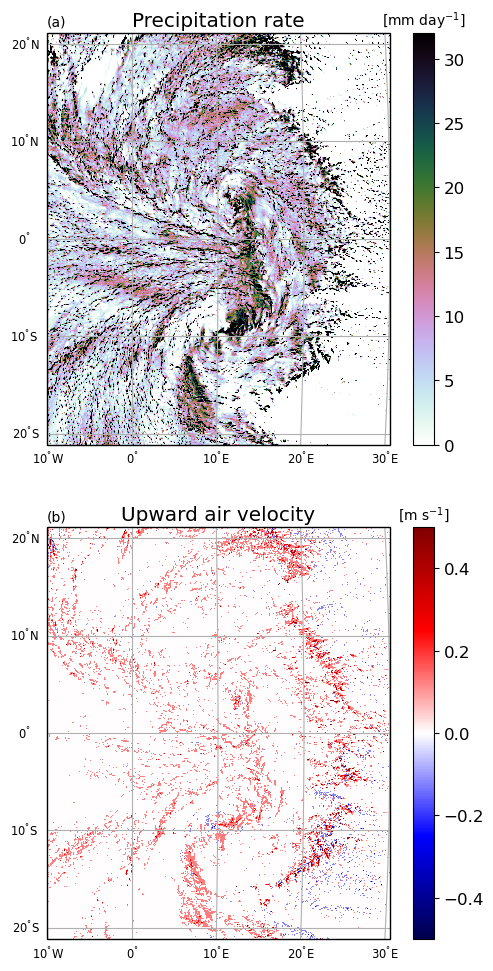

In [15]:
fig

And save it.

In [16]:
imgname = mypaths.plotdir / f"{planet}__{run_key}__precip_w_map.png"

In [17]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/proxb__grcs__precip_w_map.png
